In [1]:
import logging

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import norm

from Preprocessing import Preprocessing

# Anomaly detection

In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

df = pd.read_excel('Project 2_2023.xlsx', sheet_name='Data', parse_dates=['Date'], date_parser=date_parser)
df = df.set_index('Date')
df.index.name = 'Date'
df['Balance_correct'] = df['Income'] - df['Outcome']

<ipython-input-2-c6ce57fc7f23>:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_excel('Project 2_2023.xlsx', sheet_name='Data', parse_dates=['Date'], date_parser=date_parser)


In [270]:
prep = Preprocessing()
# series = prep.preprocess(df['Balance_correct'])
series = prep.preprocess(df['Income'])

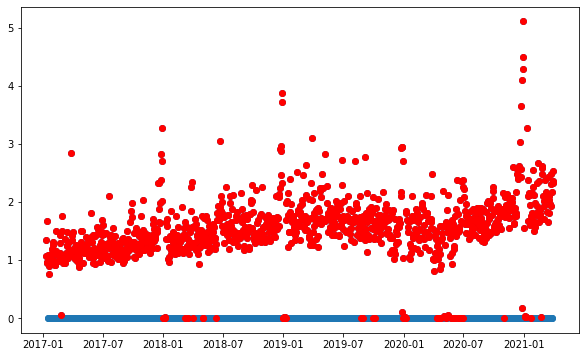

In [271]:
plt.figure(figsize=(10,6))

# x = series[83:90]
# for year in range(1,2):
#     x = series[365 * year : 357 + 365 * year]
#     plt.plot(x)

# plt.scatter(series.index, df['Income'])
plt.scatter(series.index, series)
plt.scatter(series[series != 0].index, series[series != 0], color='r')

(array([ 13.,   7.,   0.,   9.,   0.,   6.,   8.,   0., 198., 210.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

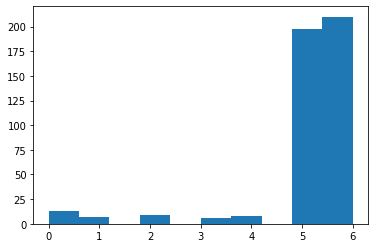

In [272]:
zero_days = np.array([date.weekday() for date in series[series == 0].index])
plt.hist(zero_days)

In [1]:
from Calendar import RussianBusinessCalendar

calendar = RussianBusinessCalendar()

In [2]:
calendar.get_holidays()

[Holiday: Russian Day Off (year=2017, month=1, day=1, ),
 Holiday: Russian Day Off (year=2017, month=1, day=2, ),
 Holiday: Russian Day Off (year=2017, month=1, day=3, ),
 Holiday: Russian Day Off (year=2017, month=1, day=4, ),
 Holiday: Russian Day Off (year=2017, month=1, day=5, ),
 Holiday: Russian Day Off (year=2017, month=1, day=6, ),
 Holiday: Russian Day Off (year=2017, month=1, day=7, ),
 Holiday: Russian Day Off (year=2017, month=1, day=8, ),
 Holiday: Russian Day Off (year=2017, month=2, day=22, ),
 Holiday: Russian Day Off (year=2017, month=2, day=23, ),
 Holiday: Russian Day Off (year=2017, month=2, day=24, ),
 Holiday: Russian Day Off (year=2017, month=3, day=7, ),
 Holiday: Russian Day Off (year=2017, month=3, day=8, ),
 Holiday: Russian Day Off (year=2017, month=5, day=1, ),
 Holiday: Russian Day Off (year=2017, month=5, day=8, ),
 Holiday: Russian Day Off (year=2017, month=5, day=9, ),
 Holiday: Russian Day Off (year=2017, month=6, day=12, ),
 Holiday: Russian Day Off (

In [296]:
df = pd.DataFrame(series, columns=["val"])
df['date'] = df.index.date
df['week_day'] = df['date'].apply(lambda x: x.weekday())
df['month_day'] = df['date'].apply(lambda x: x.day)
df

,val,date,week_day,month_day
2017-01-09,1.343028,2017-01-09,0,9
2017-01-10,1.068610,2017-01-10,1,10
2017-01-11,0.944429,2017-01-11,2,11
2017-01-12,1.672202,2017-01-12,3,12
2017-01-13,0.955924,2017-01-13,4,13
...,...,...,...,...
2021-03-27,0.000000,2021-03-27,5,27
2021-03-28,0.000000,2021-03-28,6,28
2021-03-29,2.356883,2021-03-29,0,29
2021-03-30,2.317382,2021-03-30,1,30


In [227]:
import seaborn as sns
from collections import Counter
from matplotlib.ticker import MaxNLocator, FuncFormatter

class AnomalyDetector(object):
    """
    Class which use CUSUM anomaly detection.
    A cumulative sum (CUSUM) chart is a type of control chart used to monitor small shifts in the process mean.
    Parameters
    ----------
    backward_window_size : integer, optional, default 30
        The window size of timeseries for estimate stats (like train)
    forward_window_size : integer, optional, default 14
        The window size of timeseries for compare with backward_window_size (like test)
    threshold : float, optional, default 5.0
        The maximum(minimum, with opposite sign) value of cumulative changes
    drift : float, optional, default 1.0
        The permissible deviation of timeseries from the mean
    Attributes
    ----------
    anomalies_ : timeseries of binary value (with initial timeseries index), where 1 - anomaly, 0 - non-anomaly
    """

    def __init__(self, backward_window_size=30, forward_window_size=14, threshold=5.0, drift=1.0):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift
        self.anomalies_ = None

    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Detect anomaly in one pass
        Parameters
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Train sample to calculate statistics of timeseries
        prediction_zone : pandas.Series or pandas.DataFrame
            Test sample to find anomaly variables
        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`
        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``
        Returns
        -------
        is_fault : binary numpy array, shape = [len(prediction_zone)]
            1 - anomaly, 0 - nonanomaly
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i - 1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i - 1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Detect anomaly in rolling window (=forward_window_size)
        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries
        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`
        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``
        excluded_points : pandas.Series.index
            Acquainted anomaly events. They will be removed from timeseries before anomaly detection
        Returns
        -------
        self.anomalies_ : pandas.Series, shape = [len(time_series)]
            Labeled timeseries with anomaly, where 1 - anomaly, 0 - nonanomaly
        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        self.anomalies_ = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

    def plot(self, time_series, ax=None, figsize=(14, 7),
             xlabel='Дата', ylabel='тысяч рублей', title='Plot Cusum Anomaly Detection',
             grid=True, marketsize=5):
        """
        Plot timeseries with anomaly points
        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries
        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot
        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot
        xlabel : string, optional, default 'Дата'
            Label of x axis
        ylabel : string, optional, default 'тысяч рублей'
            Label of y axis
        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot
        grid : boolean, optional, default True
            If True, use grid at plot
        marketsize : float, optional, default 5
            Size of anomaly points on timeseries plot
        Returns
        -------
        Plot timeseries with anomalies
        """
        anomalies = pd.Series(np.where(self.anomalies_ == 1, time_series, np.nan),
                              index=time_series.index)
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.plot(time_series, label='actual')
        ax.plot(anomalies, 'o', color='r', markersize=marketsize, label='anomalies')
        ax.legend(loc='best')
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    def hist(self, meas='day', th=0.15, ax=None, figsize=(14, 7),
             xlabel='День месяца', ylabel='количество аномалий', title='Hist Cusum Anomaly Detection',
             grid=True):
        """
        Plot hist of anomaly points
        Parameters
        ----------
        meas : pd.datetime attribute, optional, default 'day'
        th : float, optional, default 0.15
        time_series : pandas.Series
            Target timeseries
        ax : matplotlib object, optional, default None
            If ax is not None, use giving axis in current subplot
        figsize : tuple, optional, default (14, 7)
            If ax is None, figsize - size of plot
        xlabel : string, optional, default 'День месяца'
            Label of x axis
        ylabel : string, optional, default 'количество аномалий'
            Label of y axis
        title : string, optional, default 'Plot Cusum Anomaly Detection'
            Title of plot
        grid : boolean, optional, default True
            If True, use grid at plot
        Returns
        -------
        Plot histogramm of anomalies per month
        """

        idx, anomaly_count, periodic_anomaly_idx = self.__count_anomaly(th, meas)
        simple_color = '#36b2e2'
        anomaly_gradient_colors = dict(zip(periodic_anomaly_idx,
                                           sns.color_palette("Reds", len(periodic_anomaly_idx)).as_hex()[::-1]))
        colors = [simple_color if x[1] / sum(anomaly_count) < th else anomaly_gradient_colors[x[0]]
                  for x in zip(idx, anomaly_count)]
        fig, ax = AnomalyDetector._conf_axs(ax, figsize, xlabel, ylabel, title, grid)
        ax.set_xlim(0, max(idx))
        ax.set_ylim(0, max(anomaly_count) + 1)
        ax.bar(idx, anomaly_count, color=colors)
        handles = [(x[0], anomaly_gradient_colors[x[0]])
                   for x in zip(idx, anomaly_count) if x[1] / sum(anomaly_count) >= th]
        handles = [mpatches.Patch(color=x[1], label=x[0]) for x in handles]
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.05), fancybox=True, shadow=True)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    def __count_anomaly(self, th, meas):
        anomaly_idx = getattr(self.anomalies_[self.anomalies_ == 1].index, meas)
        count_anomalies_by_idx = sorted(Counter(anomaly_idx).items(), key=lambda x: x[1], reverse=True)
        idx = [x[0] for x in count_anomalies_by_idx]
        anomaly_count = [x[1] for x in count_anomalies_by_idx]
        periodic_anomaly_idx = [x[0] for x in count_anomalies_by_idx if x[1] / len(anomaly_idx) >= th]
        return idx, anomaly_count, periodic_anomaly_idx

    @staticmethod
    def _conf_axs(ax, figsize, xlabel, ylabel, title, grid):
        if ax is None:
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(111)
        else:
            fig = ax.get_figure()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if grid:
            ax.grid(True)
        return fig, ax

ValueError: max() arg is an empty sequence

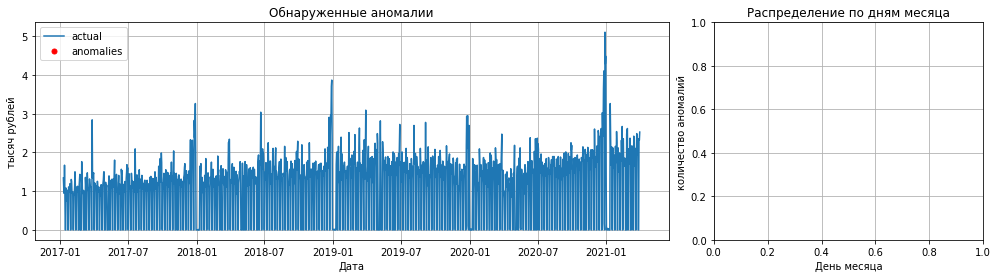

In [234]:
detector = AnomalyDetector(backward_window_size=14
                           , forward_window_size=3
#                            , threshold=3
                           , drift=series.std())
outliers = detector.detect(series)

fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(series, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
plt.show()


[27]


<BarContainer object of 25 artists>

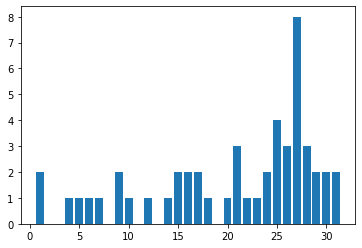

In [206]:
def count_anomaly(is_outlier, th=0.10, freq="days"):
    if freq == "days":
        anomaly_idx = [i.day for i in is_outlier[is_outlier].index]
    elif freq == "week_days":
        anomaly_idx = [i.weekday() for i in is_outlier[is_outlier].index]
    else:
        pass
            
    count_anomalies_by_idx = sorted(Counter(anomaly_idx).items(), key=lambda x: x[1], reverse=True)
    idx = [x[0] for x in count_anomalies_by_idx]
    anomaly_count = [x[1] for x in count_anomalies_by_idx]
    periodic_anomaly_idx = [x[0] for x in count_anomalies_by_idx if x[1] / len(anomaly_idx) >= th]
    return idx, anomaly_count, periodic_anomaly_idx


idx, anomaly_count, periodic = count_anomaly(outliers == 1)
print(periodic)
plt.bar(idx, anomaly_count)

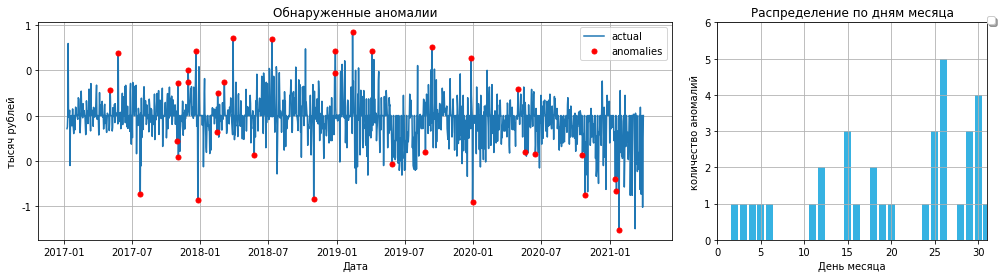

[26, 30]


<BarContainer object of 19 artists>

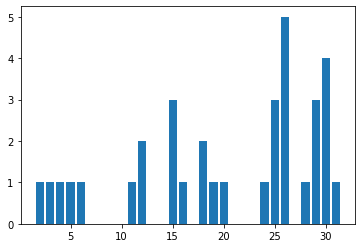

In [207]:
X = series[outliers != 1]

detector = AnomalyDetector(backward_window_size=14
                           , forward_window_size=2
                           , threshold=3
                           , drift=X.std())
second_outliers = detector.detect(X)

fig, axs = plt.subplots(1, 2, figsize=(17, 4), gridspec_kw={'width_ratios':[4, 1.7]})
plt.subplots_adjust(wspace=0.1)
detector.plot(X, ax=axs[0], title='Обнаруженные аномалии')
detector.hist(th=0.2, ax=axs[1], title='Распределение по дням месяца')
plt.show()

idx, anomaly_count, periodic = count_anomaly(second_outliers == 1)
print(periodic)
plt.bar(idx, anomaly_count)

In [150]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

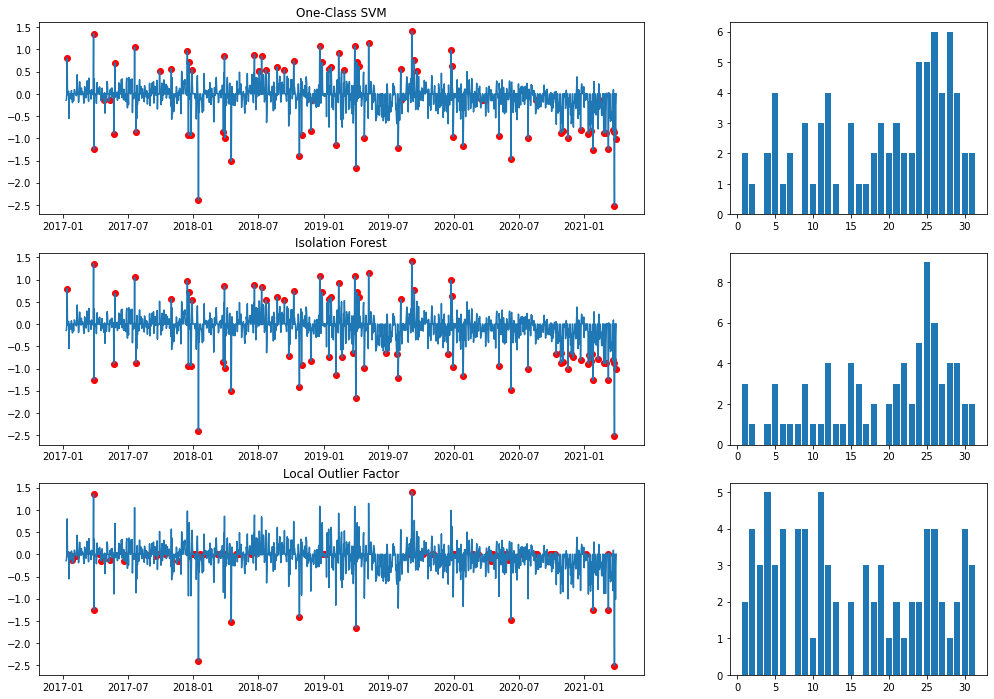

In [166]:
outliers_fraction = 0.05

anomaly_algorithms = [
    
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=1)),

    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction),
    ),
]


X = series.values.reshape(-1, 1)


fig, all_axs = plt.subplots(len(anomaly_algorithms), 2, 
                        figsize=(17, 4 * len(anomaly_algorithms)), 
                        gridspec_kw={'width_ratios':[4, 1.7]})
for axs, anomaly_algorithm in zip(all_axs, anomaly_algorithms):
    name, model = anomaly_algorithm
    if name == "Local Outlier Factor":
        preds = model.fit_predict(X)
    else:
        model.fit(X)
        preds = model.predict(X)
    is_outlier = pd.Series(preds == -1, index=series.index.date)

    
    axs[0].plot(series)
    axs[0].scatter(series.index[is_outlier], series[is_outlier], color="r")
    idx, anomaly_count, _ = count_anomaly(is_outlier)
    axs[1].bar(idx, anomaly_count)
    axs[0].set_title(name)

In [210]:
'''
Custom AnomalyDetector for univariate time-series.
Based on: https://github.com/denndimitrov/Timeseries/
'''


import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import seaborn as sns
from collections import Counter
from matplotlib.ticker import MaxNLocator, FuncFormatter


class AnomalyDetector(object):
    """
    Class which use CUSUM anomaly detection.
    A cumulative sum (CUSUM) chart is a type of control chart used to monitor small shifts in the process mean.
    Parameters
    ----------
    backward_window_size : integer, optional, default 30
        The window size of timeseries for estimate stats (like train)
    forward_window_size : integer, optional, default 14
        The window size of timeseries for compare with backward_window_size (like test)
    threshold : float, optional, default 5.0
        The maximum(minimum, with opposite sign) value of cumulative changes
    drift : float, optional, default 1.0
        The permissible deviation of timeseries from the mean
    Attributes
    ----------
    anomalies : ...
    """

    def __init__(self, backward_window_size=30, forward_window_size=14, threshold=1.0, drift=.1):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift

    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Detect anomaly in one pass
        Parameters
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Train sample to calculate statistics of timeseries
        prediction_zone : pandas.Series or pandas.DataFrame
            Test sample to find anomaly variables
        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`
        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``
        Returns
        -------
        is_fault : binary numpy array, shape = [len(prediction_zone)]
            1 - anomaly, 0 - nonanomaly
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i - 1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i - 1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Detect anomaly in rolling window (=forward_window_size)
        Parameters
        ----------
        time_series : pandas.Series
            Target timeseries
        threshold : float, optional, default 5.0
            See parameter in ``threshold`` in :class:`AnomalyDetector`:func:`__init__`
        drift : float, optional, default 1.0
            See parameter in ``drift`` in :class:`AnomalyDetector`:func:`__init__``
        excluded_points : pandas.Series.index
            Acquainted anomaly events. They will be removed from timeseries before anomaly detection
        Returns
        -------
        anomalies : pandas.Series, shape = [len(time_series)]
            Labeled timeseries with anomaly, where 1 - anomaly, 0 - nonanomaly
        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan
        
        if drift is None:
            drift = timeseries.std()

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        anomalies = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

    def detect_all(self, time_series):
        anomalies = pd.DataFrame(index=time_series.index)
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        
        return anomalies